# Creating gallery images for annotation review

**Overview:**

![revgallery](https://user-images.githubusercontent.com/22067552/80076177-c9878580-8519-11ea-8e50-9e27990f5fa6.png)

Annotation studies often focus on small *regions of interest* (ROIs) that are orders of magnitude smaller than whole slide images and sparsely distributed over many slides. Reviewing these annotations involves significant time spent navigating from one ROI to another within and across slides. To aid in review we developed tools to generate mosaic gallery images that condense these ROIs into a dense multiresolution images that can be viewed in HistomicsUI. These gallery images speed up the review process by minimizing navigation and the need for toggling annotations.

In this minimal example, we show how 29 ROIs from two slides are parsed into three
gallery images for pathologist review (a typical project may contain 100s of ROIs). This [video](https://youtube/Plh39obBg_0) demonstrates the gallery image functionality, and
the code below which shows the gallery image creation process.

**Where to look:**

```
|_histomicstk/
   |_annotations_and_masks/
      |_review_gallery.py
      |_tests/
         |_test_review_gallery.py
```

In [1]:
import os
import tempfile
import shutil
from imageio import imread
from pandas import read_csv
import girder_client
from histomicstk.annotations_and_masks.review_gallery import \
    get_all_rois_from_folder_v2, get_all_rois_from_slide_v2, \
    _plot_rapid_review_vis, create_review_galleries

import matplotlib.pylab as plt
%matplotlib inline

/home/mtageld/anaconda3/envs/wsi/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Connect girder client and set parameters

A csv file like the one in
``histomicstk/annotations_and_masks/tests/test_files/sample_GTcodes_v2.csv`` is needed to define what group each pixel value corresponds to in the mask image, to define the overlay order of various annotation groups, and which groups are considered to be ROIs. Note that the term "group" here comes from the annotation model where each group represents a class like "tumor" or "necrosis" and is associated with a an annotation style.
Please refer to *"Converting annotations to semantic segmentation mask images"* for more details.

In [ ]:
URL = 'http://candygram.neurology.emory.edu:8080/'
APIURL = URL + 'api/v1/'

# source folder containing slides with annotated ROIs
SAMPLE_FOLDER_ID = '5e2a2da8ddda5f83986d18a2'

# This is the girder folder where galleries will be visualized
POST_FOLDERID = "5e3ce440ddda5f839875b33e"

# Connect to an authenticated girder API. You 
gc = girder_client.GirderClient(apiUrl=APIURL)
gc.authenticate(interactive=True)  # need this to post!
# gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

# GT codes dict for parsing into label mask
GTCODE_PATH = os.path.join(
    '/home/mtageld/Desktop/HistomicsTK/histomicstk/annotations_and_masks/',
    'tests/test_files', 'sample_GTcodes_v2.csv')
GTCodes_dict = read_csv(GTCODE_PATH)
GTCodes_dict.index = GTCodes_dict.loc[:, 'group']
GTCodes_dict = GTCodes_dict.to_dict(orient='index')

# just a temp directory to save masks
BASE_SAVEPATH = tempfile.mkdtemp()
SAVEPATHS = {
    'contours': os.path.join(BASE_SAVEPATH, 'contours'),
    'rgb': os.path.join(BASE_SAVEPATH, 'rgbs'),
    'visualization': os.path.join(BASE_SAVEPATH, 'vis'),
}
for _, savepath in SAVEPATHS.items():
    os.mkdir(savepath)

# where to save gallery
combinedvis_savepath = os.path.join(BASE_SAVEPATH, 'combinedvis')
os.mkdir(combinedvis_savepath)

Let's take a look at some of the inputs

In [3]:
print(list(GTCodes_dict.keys()))
print(GTCodes_dict['tumor'])

['fov_preapproved', 'fov_for_programmatic_edit', 'fov_basic', 'fov_representative', 'fov_problematic', 'fov_discordant', 'tumor', 'fibroblast', 'lymphocyte', 'plasma_cell', 'macrophage', 'mitotic_figure', 'vascular_endothelium', 'myoepithelium', 'apoptotic_body', 'neutrophil', 'ductal_epithelium', 'eosinophil', 'unlabeled']
{'group': 'tumor', 'overlay_order': 1, 'GT_code': 1, 'is_roi': 0, 'is_background_class': 0, 'color': 'rgb(255,0,0)', 'comments': nan}


In [4]:
print(SAVEPATHS)
print('combinedvis_savepath:', combinedvis_savepath)

{'contours': '/tmp/tmpnwf5oe7l/contours', 'rgb': '/tmp/tmpnwf5oe7l/rgbs', 'visualization': '/tmp/tmpnwf5oe7l/vis'}
combinedvis_savepath: /tmp/tmpnwf5oe7l/combinedvis


## Retrieve ROIs from server and generate visualizations

The first step is to retrieve annotations and images of the ROIs from the server and store these locally in the
temporary directory we created. The ROI images and annotations will be combined to form new images that embed the annotations and generate visualizations. Later, another method will be used to combine these ROIs into a gallery image and to post it to DSA.

### Explore the methods

In [5]:
print(get_all_rois_from_folder_v2.__doc__)

Get all rois in a girder folder using get_all_rois_from_slide_v2().

    Parameters
    ----------
    gc : girder_client.Girder_Client
        authenticated girder client
    folderid : str
        girder id of folder
    get_all_rois_kwargs : dict
        kwargs to pass to get_all_rois_from_slide_v2()
    monitor : str
        monitor prefix

    Returns
    -------
    None

    


This calls the method `get_all_rois_from_slide_v2()` to get the rois for each
individual slide. We don't need the masks here, only the contours and
visualization.

In [6]:
print(get_all_rois_from_slide_v2.__doc__)

Get all ROIs for a slide without an intermediate mask form.

    This mainly relies on contours_to_labeled_object_mask(), which should
    be referred to for extra documentation.

    This can be run in either the "object" mode, whereby the saved masks
    are a three-channel png where first channel encodes class label (i.e.
    same as semantic segmentation) and the product of the values in the
    second and third channel encodes the object ID. Otherwise, the user
    may decide to run in the "semantic" mode and the resultant mask would
    consist of only one channel (semantic segmentation with no object
    differentiation).

    The difference between this and version 1, found at
    histomicstk.annotations_and_masks.annotations_to_masks_handler.
    get_all_rois_from_slide()
    is that this (version 2) gets the contours first, including cropping
    to wanted ROI boundaries and other processing using shapely, and THEN
    parses these into masks. This enables us to differentiate

 We will be `get_all_rois_from_folder_v2()` will the callback function
 `_plot_rapid_review_vis()` to create a "combined" side-by-side visualization
 of the annotations and the RGB image, along with a lower magnification RGB image that provides context for the ROI.

In [7]:
print(_plot_rapid_review_vis.__doc__)

Plot a visualization for rapid review of ROI.

    This is a callback to be called inside get_all_rois_from_slide_v2().

    Parameters
    ----------
    roi_out : dict
        output from annotations_to_contours_no_mask()
    gc : girder_client.Girder_Client
        authenticated girder client
    slide_id : str
        girder slide id
    slide_name : str
        name of the slide
    MPP : float
        microns per pixel
    MAG : float
        magnification. superceded by MPP.
    combinedvis_savepath : str
        path to save the combined visualization
    zoomout : float
        how much to zoom out to get the gallery visualization
    verbose : bool
        print statements to screen
    monitorprefix : str
        text to prepent to printed statements

    Returns
    -------
    None

    


In [8]:
# params for getting all rois for slide
get_all_rois_kwargs = {
    'GTCodes_dict': GTCodes_dict,
    'save_directories': SAVEPATHS,
    'annotations_to_contours_kwargs': {
        'MPP': 0.2,
        'linewidth': 0.2,
        'get_rgb': True,
        'get_visualization': True,
    },
    'verbose': False,
    'get_mask': False,
    # we use this callback so that we have results compatible
    # of being used as input for create_review_galleries()
    'callback': _plot_rapid_review_vis,
    'callback_kwargs': {
        'combinedvis_savepath': combinedvis_savepath,
        'zoomout': 4,

    },
}

### Generate and examine the visualizations

Execute this function using the girder client and folder id.

In [9]:
# Get al rois to prep for gallery
get_all_rois_from_folder_v2(
    gc=gc, folderid=SAMPLE_FOLDER_ID,
    get_all_rois_kwargs=get_all_rois_kwargs, monitor='test')

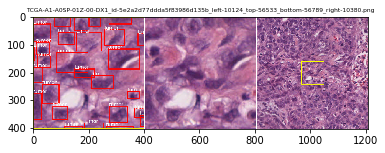

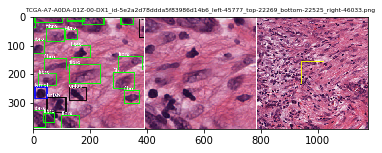

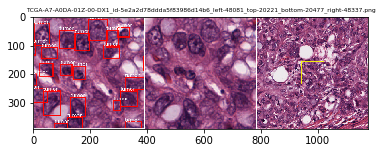

In [10]:
all_fovs = os.listdir(combinedvis_savepath)
for i in range(3):
    cvis = imread(os.path.join(combinedvis_savepath, all_fovs[i]))
    plt.imshow(cvis)
    plt.title(all_fovs[i], fontsize=6)
    plt.show()

## Assemble visualizations into gallery image and post to server

After the visualizations are created we need to assemble them into larger gallery images for review and post these back to the server.

This is the method we will be using:

In [11]:
print(create_review_galleries.__doc__)

Create and or post review galleries for rapid review.

    Parameters
    ----------
    tilepath_base : str
        directory where combined visualization.
    upload_results : bool
        upload results to DSA?
    gc : girder_client.Girder_Client
        authenticated girder client. Only needed upload_results.
    gallery_savepath : str
        directory to save gallery. Only if upload_results.
    gallery_folderid : str
        girder ID of folder to post galleries. Only if upload_result.
    padding : int
        padding in pixels between tiles in same gallery.
    tiles_per_row : int
        how many visualization tiles per row in gallery.
    tiles_per_column : int
        how many visualization tiles per column in gallery.
    annprops : dict
        properties of the annotations to be posted to DSA. Passed directly
        as annprops to get_annotation_documents_from_contours()
    url : str
        url of the Digital Slide Archive Instance. For example:
        http://candyg

In [12]:
create_review_galleries_kwargs = {
    'tilepath_base': combinedvis_savepath,
    'upload_results': True,
    'gc': gc,
    'url': URL,
    'gallery_folderid': POST_FOLDERID,
    'gallery_savepath': None,
    'padding': 25,
    'tiles_per_row': 2,
    'tiles_per_column': 5,
}

In [13]:
# create (+/- post) review gallery
resps = create_review_galleries(**create_review_galleries_kwargs)

Inserting tile 0 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-10124_top-56533_bottom-56789_right-10380.png
Inserting tile 1 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-7308_top-55253_bottom-55509_right-7564.png
Inserting tile 2 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-8076_top-55509_bottom-55765_right-8332.png
Inserting tile 3 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-8076_top-56021_bottom-56277_right-8332.png
Inserting tile 4 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-8076_top-57045_bottom-57301_right-8332.png
Inserting tile 5 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-5e2a2d77ddda5f83986d135b_left-8332_top-54485_bottom-54741_right-8588.png
Inserting tile 6 of 29: /tmp/tmpnwf5oe7l/combinedvis/TCGA-A1-A0SP-01Z-00-DX1_id-

Now you can go to the girder folder where galleries will be visualized
on HistomicsUI.

## Cleanup

The contents of the temporary directory are no longer needed after posting to the server.

In [14]:
shutil.rmtree(BASE_SAVEPATH)